## Carregando Pacotes

In [48]:
# Imports
import cv2
import sys
import wand
import torch
import scipy
import typing
import matplotlib
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import glob
from skimage.io import imread, imread_collection
from PIL import Image
from torchvision.models.vgg import vgg19
from wand.image import Image as WImage
from scipy.spatial.distance import cdist
from cv2.ximgproc import guidedFilter
from typing import List

### Versões Usadas

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

numpy      : 1.18.5
torch      : 1.11.0
PIL        : 9.0.0
matplotlib : 3.3.4
cv2        : 4.5.5
sys        : 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
torchvision: 0.12.0
scipy      : 1.4.1



In [3]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Vamos checar se a GPU está disponível e se estiver, usaremos como device. Caso contrário, usamos a CPU.

In [4]:
# Checando o tipo de dispositivo
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Carregando as Imagens Para Testar o Procedimento de Fusão

In [5]:
# Função para leitura da imagem
# Para detalhes sobre o mode, consulte:
# https://pillow.readthedocs.io/en/3.1.x/handbook/concepts.html#concept-modes
def leitura_imagem(imagem, mode):
    return np.array(Image.open(imagem).convert(mode))

In [6]:
# Usaremos 2 imagens de exemplo
lista_imagens = ['Fusion/vista01.png', 'Fusion/objeto01.png']

In [7]:
# Fazemos a leitura das imagens com mode = L
imagens = [leitura_imagem(p, mode = 'L') for p in lista_imagens]

In [8]:
# Shape das imagens
print(imagens[0].shape, imagens[1].shape)

(475, 575) (475, 575)


Text(0.5, 1.0, 'Second Image')

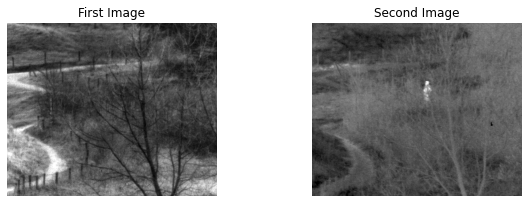

In [9]:
# Visualiza as imagens

fig = plt.figure(figsize=(10, 7)) 
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1) 
plt.imshow(imagens[0], cmap='gray') 
plt.axis('off') 
plt.title("First Image") 
fig.add_subplot(rows, columns, 2) 
plt.imshow(imagens[1], cmap='gray') 
plt.axis('off') 
plt.title("Second Image") 

In [10]:
# Normalizamos as imagens
imagens_normalizadas = [(img / 255.).astype(np.float32) for img in imagens]

Text(0.5, 1.0, 'Second Image')

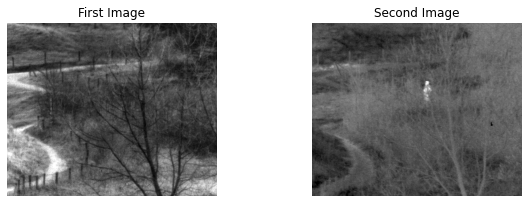

In [11]:
# Visualiza as imagens normalizadas

fig = plt.figure(figsize=(10, 7)) 
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1) 
plt.imshow(imagens_normalizadas[0], cmap='gray') 
plt.axis('off') 
plt.title("First Image") 
fig.add_subplot(rows, columns, 2) 
plt.imshow(imagens_normalizadas[1], cmap='gray') 
plt.axis('off') 
plt.title("Second Image") 

## Funções Para o Procedimento de Fusão

As duas funções abaixo serão usadas para aplicar filtro às imagens e então fazer a decomposição.

In [12]:
# Função para extrair os detalhes da imagem aplicando filtro 
# O processo de filtragem é muito usado para extrair os ruídos, e nesse caso é exatamete o que queremos separar
def filtra_imagem(img, k = (15, 15)):
    
    # Verifica o tipo da imagem (array)
    assert img.dtype == np.float32 and img.max() <= 1., 'imagem precisa ser np.float32'
    
    # Cria o objeto de remoção de ruído com blur
    base = cv2.blur(img, k)
    
    # Faz a operação extraindo o ruído da imagem
    detail = img - base
    
    return base, detail

In [13]:
# Função para decomposição das imagens
def decompose_imagem(imagens_norm):
    
    # Listas para base e detalhes
    bases, details = [], []
    
    # Loop pelas imagens normalizadas
    for img_n in imagens_norm:
        
        # Aplicação a função de filtro
        base, detail = filtra_imagem(img_n)
        
        # Cria a lista de bases das imagens
        bases.append(base)
        
        # Cria a lista de ruídos (detalhes) das imagens
        details.append(detail)
        
    return bases, details

In [14]:
# Aplica a decomposição
bases, details = decompose_imagem(imagens_normalizadas)

Text(0.5, 1.0, 'Second Image')

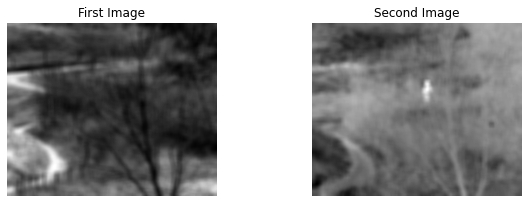

In [15]:
# Visualiza as bases

fig = plt.figure(figsize=(10, 7)) 
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1) 
plt.imshow(bases[0], cmap='gray') 
plt.axis('off') 
plt.title("First Image") 
fig.add_subplot(rows, columns, 2) 
plt.imshow(bases[1], cmap='gray') 
plt.axis('off') 
plt.title("Second Image") 

Text(0.5, 1.0, 'Second Image')

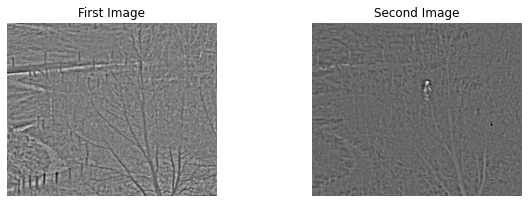

In [16]:
# Visualiza os detalhes

fig = plt.figure(figsize=(10, 7)) 
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1) 
plt.imshow(details[0], cmap='gray') 
plt.axis('off') 
plt.title("First Image") 
fig.add_subplot(rows, columns, 2) 
plt.imshow(details[1], cmap='gray') 
plt.axis('off') 
plt.title("Second Image") 

As funções abaixo serão usadas para extrair as saliências das imagens, o que será usado para a fusão.

In [17]:
# Função para extrair as saliências das imagens
def extrai_saliencia(img, D):
    
    # Verifica o tipo da imagem
    assert img.dtype == np.uint8, 'imagem precisa estar como np.uint8'
    
    # Conta o número de ocorrências de cada pixel
    # https://numpy.org/doc/stable/reference/generated/numpy.bincount.html
    hist = np.bincount(img.flatten(), minlength = 256) / img.size
    
    # Calcula os valores que representam saliência
    sal_values = np.dot(hist, D)
    
    # Extrai as saliências
    saliency = sal_values[img]
    
    return saliency

In [18]:
# Função que gera os pesos das saliências
def gera_pesos_saliencias(imgs):
    
    # O objeto D será usado para calcular as distâncias euclidianas
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    D = cdist(np.arange(256).reshape(-1, 1), np.arange(256).reshape(-1, 1))
    
    # Os pesos das saliências serão calculdos com base nas saliências e nas distâncias
    Ws = [extrai_saliencia(img, D) for img in imgs]
    
    # Inclui um valor de correção (algo parecido com a taxa de aprendizado)
    # https://numpy.org/doc/stable/reference/generated/numpy.dstack.html
    Ws = np.dstack(Ws) + 1e-12
    
    # Gera os pesos finais
    Ws = Ws / Ws.sum(axis = 2, keepdims = True)
    return Ws

O guided filter realiza suavização com preservação de borda em uma imagem, usando o conteúdo de uma segunda imagem, chamada imagem de orientação, para influenciar a filtragem. A imagem de orientação pode ser a própria imagem, uma versão diferente da imagem ou uma imagem completamente diferente. A **filtragem guiada de imagem** é uma operação de vizinhança, como outras operações de filtragem, mas leva em consideração as estatísticas de uma região na vizinhança espacial correspondente na imagem de orientação ao calcular o valor do pixel de saída.

Exemplo visual:

https://www.mathworks.com/help/images/what-is-guided-image-filtering.html

In [19]:
# Função para otimização dos pesos das imagens
# https://en.wikipedia.org/wiki/Edge-preserving_smoothing
# https://github.com/opencv/opencv_contrib/tree/master/modules/ximgproc
def guided_optimize(guides, srcs, r, eps):
    
    # Filtro da imagem mantendo as bordas
    Ws = [guidedFilter(guide.astype(np.float32), src.astype(np.float32), r, eps) for guide, src in zip(guides, srcs)]
    
    # Matriz de peso com fator de correção
    Ws = np.dstack(Ws) + 1e-12
    
    # Matriz final
    Ws = Ws / Ws.sum(axis = 2, keepdims = True)
    
    return Ws

## Gerando os Pesos das Saliências Para Fusão das Bases

In [20]:
# Executa a função de geração de pesos
Wb_0 = gera_pesos_saliencias(imagens)

In [21]:
# Shape
Wb_0.shape

(475, 575, 2)

In [22]:
# Ajusta o shape da matriz de peso
Wb_0 = np.moveaxis(Wb_0, -1, 0) 

In [23]:
# Shape
Wb_0.shape

(2, 475, 575)

In [24]:
# Parâmetros para o guided filter
# http://kaiminghe.com/publications/eccv10guidedfilter.pdf
r1 = 45
eps1 = 0.01

In [25]:
# Pesos finais otimizados
Wb = guided_optimize(imagens_normalizadas, Wb_0, r1, eps1)

In [26]:
# Função para a soma da multiplicação de pesos pelas bases das imagens
def pesos_imagens(imgs, ws):
    return np.sum(ws * np.dstack(imgs), axis = 2)

## Fusão das Bases das Imagens

In [27]:
# Fusão das bases das imagens com base nos pesos
fusao_bases = pesos_imagens(bases, Wb)

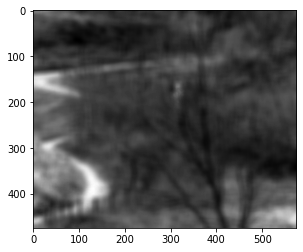

In [28]:
# Visualização
plt.imshow(fusao_bases, cmap='gray')

## Fusão dos Detalhes das Imagens

In [29]:
# Função para converter os detalhes das imagens em tensores
def convert_to_tensor(imgs: List[np.ndarray]):
    
    # Lista temporária
    tmp = []
    
    # Loop pelas imagens
    for img in imgs:
        if img.dtype == np.uint8:
            img = (img / 255.).astype(np.float32)
        if img.ndim == 2:
            img = np.expand_dims(img, (0, 1))
            tmp.append(np.repeat(img, 3, axis = 1))
            
    return torch.from_numpy(np.vstack(tmp))

In [30]:
# Detalhes das imagens convertidos para tensor
details_tensor = convert_to_tensor(details)

In [31]:
# Visualiza
details_tensor

tensor([[[[ 0.1507,  0.1736,  0.1184,  ...,  0.0240,  0.0146, -0.0280],
          [ 0.2100,  0.2210,  0.1930,  ...,  0.1061,  0.0572,  0.0027],
          [ 0.1383,  0.1258,  0.1015,  ...,  0.0674,  0.0532,  0.0023],
          ...,
          [-0.0152, -0.0397, -0.0342,  ..., -0.1093, -0.0519,  0.0091],
          [-0.1059, -0.0836, -0.0353,  ..., -0.1308, -0.0963, -0.0192],
          [-0.0998, -0.0580, -0.0297,  ..., -0.1579, -0.1351, -0.0894]],

         [[ 0.1507,  0.1736,  0.1184,  ...,  0.0240,  0.0146, -0.0280],
          [ 0.2100,  0.2210,  0.1930,  ...,  0.1061,  0.0572,  0.0027],
          [ 0.1383,  0.1258,  0.1015,  ...,  0.0674,  0.0532,  0.0023],
          ...,
          [-0.0152, -0.0397, -0.0342,  ..., -0.1093, -0.0519,  0.0091],
          [-0.1059, -0.0836, -0.0353,  ..., -0.1308, -0.0963, -0.0192],
          [-0.0998, -0.0580, -0.0297,  ..., -0.1579, -0.1351, -0.0894]],

         [[ 0.1507,  0.1736,  0.1184,  ...,  0.0240,  0.0146, -0.0280],
          [ 0.2100,  0.2210,  

In [32]:
# Verificando o tipo do objeto
type(details_tensor)

torch.Tensor

## Carregando o Modelo Pré-Treinado VGG19

Modelo VGG19

https://arxiv.org/abs/1409.1556

In [33]:
# Carrega o modelo pré-treinado
# https://pytorch.org/docs/stable/torchvision/models.html
modelo = vgg19(pretrained = True)

In [34]:
# Define as camadas com função de ativação relu
vgg19_relus = [1, 3, 8]

Função que aplica o modelo pré-treinado para encontrar os pesos ideais para fusão dos detalhes das imagens.

In [35]:
# Função que aplica o modelo pré-treinado para encontrar os pesos para fusão dos detalhes das imagens.
def fusao_detalhes_cnn(inp, modelo, device, relus):
    
    # Coloca o modelo no device
    modelo.to(device)
    modelo.eval()

    # Prepara input e output
    inp = inp.to(device)
    out = inp
    
    # Lista de pesos
    Wls = []  
    
    # Loop pelos pesos
    with torch.no_grad():
        
        # Loop pelas relus
        for i in range(max(relus) + 1):
            
            # Extrai as features usando o modelo pré-treinado
            out = modelo.features[i](out)
            
            # Se a camada relu estiver na lista de relus, aplicamos interpolação
            # https://pytorch.org/docs/stable/nn.functional.html
            if i in relus:
                
                # Aplicamos interpolação às imagens para reduzir a escala
                l1_feat = (F.interpolate(out, inp.shape[-2:]).norm(1, dim = 1, keepdim = True))  
                
                # Gera os pesos da camada softmax
                w_l = F.softmax(l1_feat, dim = 0)
                
                # Gera lista de pesos
                Wls.append(w_l)

    # Tensor para receber a saliência máxima
    saliency_max = -np.inf * torch.ones((3,) + inp.shape[-2:])
    saliency_max = saliency_max.to(device)
    
    # Loop pelos pesos para extrair a saliência máxima
    for w_l in Wls:
        saliency_curr = (inp * w_l).sum(0)
        saliency_max = torch.max(saliency_max, saliency_curr)

    # Obtendo a saliência máxima na imagem
    fused_detail = saliency_max
    
    # Retornamos o resultado como array NumPy
    return to_numpy(fused_detail[0])

In [36]:
# Função para converter para formato Numpy
def to_numpy(t):
    a = t.squeeze().detach().cpu().numpy()
    if a.ndim == 3:
        np.moveaxis(a, 0, -1)
    return a

In [37]:
# Executa a função
fusao_detalhes = fusao_detalhes_cnn(details_tensor, modelo, device, relus = vgg19_relus)

In [38]:
# Agora unimos as fusões das bases e dos detalhes e geramos a fusão final, limitando o tamanho de cada array
# https://numpy.org/doc/stable/reference/generated/numpy.clip.html
fusao_final = np.clip(fusao_bases + fusao_detalhes, 0, 1)

In [39]:
# Arredondamos os valores para o inteiro mais próximo
# https://numpy.org/doc/stable/reference/generated/numpy.rint.html
fusao_final = np.rint(fusao_final * 255).astype(np.uint8)

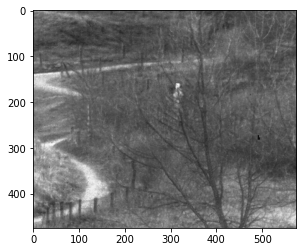

In [40]:
# Visualiza o resultado
plt.imshow(fusao_final, cmap='gray')

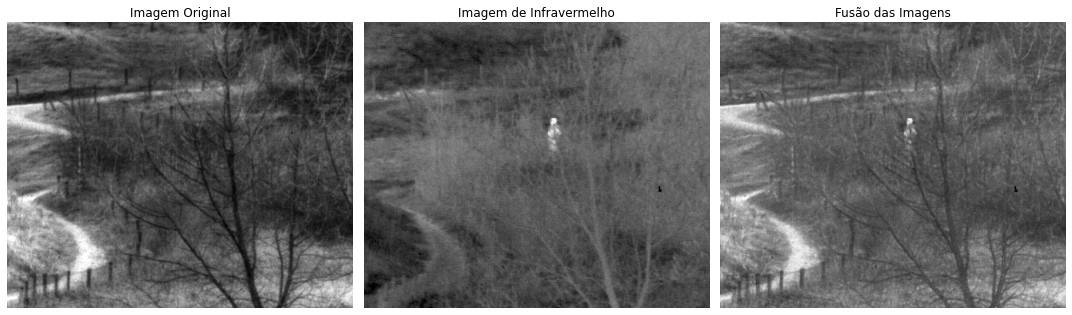

In [41]:
# Plot
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(imagens[0], cmap = 'gray')
axes[0].set_title('Imagem Original')
axes[1].imshow(imagens[1], cmap = 'gray')
axes[1].set_title('Imagem de Infravermelho')
axes[2].imshow(fusao_final, cmap = 'gray')
axes[2].set_title('Fusão das Imagens')
for ax in axes:
    ax.axis('off')
fig.tight_layout()

## Fusão de Imagens Médicas

Para a fusão de imagens médicas, usaremos um app com o código automatizado.

**Execute aqui mesmo pelo Jupyter Notebook, executando a célula abaixo.**

In [42]:
!python Zero-Learning/app.py --CaminhoImagens=Fusion --Imagens "MRI*.png" "PET*.png"


Fusão entre as imagens => f['MRI-01.png', 'PET-01.png']

Fusão entre as imagens => f['MRI-02.png', 'PET-02.png']

Fusão entre as imagens => f['MRI-03.png', 'PET-03.png']

Fusão Concluída!



Os resultados das fusões são armazenados no formato .png, juntamente com um relatório gravado em formato pdf.

In [60]:
# Imagens
path_imagens = sorted(glob.glob('Fusion/*.png'))
imagens = imread_collection(path_imagens)

In [61]:
# Fusão
path_fusion = sorted(glob.glob('resultado/Fusion/*.png'))
fusion = imread_collection(path_fusion)

### Fusão 1

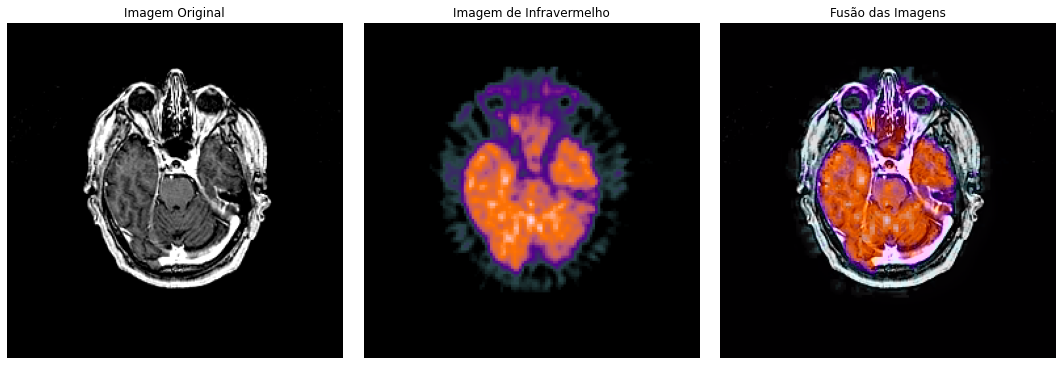

In [69]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(imagens[0], cmap = 'gray')
axes[0].set_title('Imagem Original')
axes[1].imshow(imagens[3], cmap = 'gray')
axes[1].set_title('Imagem de Infravermelho')
axes[2].imshow(fusion[0], cmap = 'gray')
axes[2].set_title('Fusão das Imagens')
for ax in axes:
    ax.axis('off')
fig.tight_layout()

### Fusão 2

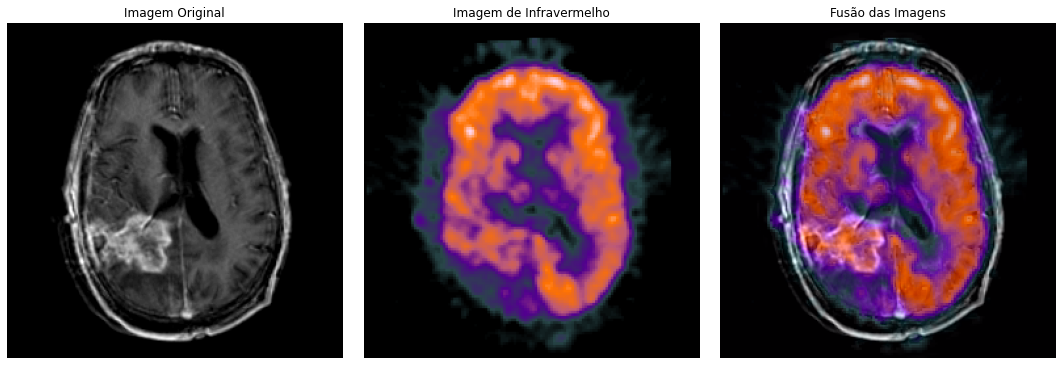

In [70]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(imagens[1], cmap = 'gray')
axes[0].set_title('Imagem Original')
axes[1].imshow(imagens[4], cmap = 'gray')
axes[1].set_title('Imagem de Infravermelho')
axes[2].imshow(fusion[1], cmap = 'gray')
axes[2].set_title('Fusão das Imagens')
for ax in axes:
    ax.axis('off')
fig.tight_layout()

### Fusão 3

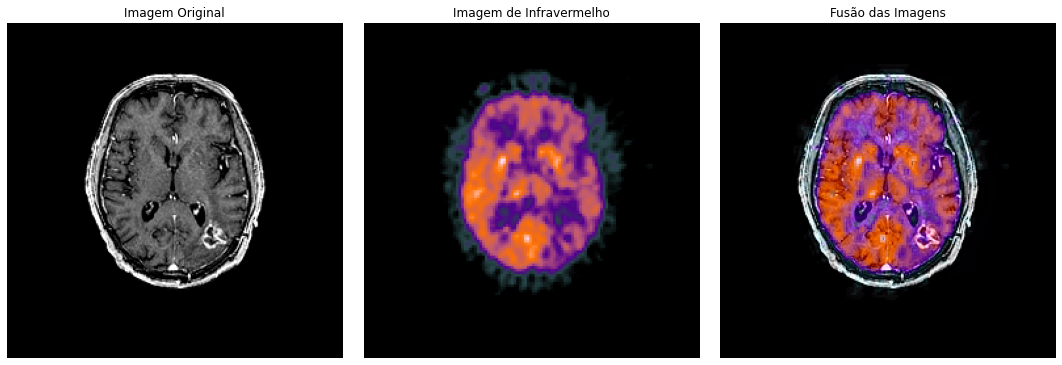

In [72]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(imagens[2], cmap = 'gray')
axes[0].set_title('Imagem Original')
axes[1].imshow(imagens[5], cmap = 'gray')
axes[1].set_title('Imagem de Infravermelho')
axes[2].imshow(fusion[2], cmap = 'gray')
axes[2].set_title('Fusão das Imagens')
for ax in axes:
    ax.axis('off')
fig.tight_layout()